In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
filepath = os.getcwd() + '/datasets/'

合并 ab_test_imp 和 ab_test_goal 的数据

In [3]:
## 读入数据
ab_test_imp = pd.read_csv(filepath + 'section5-ab_test_imp.csv')
ab_test_goal = pd.read_csv(filepath + 'section5-ab_test_goal.csv')
## 合并数据
ab_test_imp = ab_test_imp.merge(ab_test_goal, how='left', on='transaction_id', suffixes=['', '_g'])
ab_test_imp.head()

,log_date,app_name,test_name,test_case,user_id,transaction_id,log_date_g,app_name_g,test_name_g,test_case_g,user_id_g
0,2013-10-01,game-01,sales_test,B,36703,25622,NaN,NaN,NaN,NaN,NaN
1,2013-10-01,game-01,sales_test,A,44339,25623,NaN,NaN,NaN,NaN,NaN
2,2013-10-01,game-01,sales_test,B,32087,25624,NaN,NaN,NaN,NaN,NaN
3,2013-10-01,game-01,sales_test,B,10160,25625,NaN,NaN,NaN,NaN,NaN
4,2013-10-01,game-01,sales_test,B,46113,25626,NaN,NaN,NaN,NaN,NaN


生成用于标识点击情况的标志位

In [4]:
ab_test_imp['is_goal'] = np.where(ab_test_imp['user_id_g'].isnull(), 0, 1)
ab_test_imp.head()

,log_date,app_name,test_name,test_case,user_id,transaction_id,log_date_g,app_name_g,test_name_g,test_case_g,user_id_g,is_goal
0,2013-10-01,game-01,sales_test,B,36703,25622,NaN,NaN,NaN,NaN,NaN,0
1,2013-10-01,game-01,sales_test,A,44339,25623,NaN,NaN,NaN,NaN,NaN,0
2,2013-10-01,game-01,sales_test,B,32087,25624,NaN,NaN,NaN,NaN,NaN,0
3,2013-10-01,game-01,sales_test,B,10160,25625,NaN,NaN,NaN,NaN,NaN,0
4,2013-10-01,game-01,sales_test,B,46113,25626,NaN,NaN,NaN,NaN,NaN,0


统计点击率

In [5]:
## 计算点击率
ab_test_imp.groupby(by=['test_case']).apply(lambda grp: sum(grp.is_goal)/len(grp.user_id)).rename('ctr').reset_index()

,test_case,ctr
0,A,0.080256
1,B,0.115460


进行卡方检验

In [6]:
# from scipy import stats

# a = list(ab_test_imp.loc[ab_test_imp['test_case'] == 'A', 'is_goal'])
# b = list(ab_test_imp.loc[ab_test_imp['test_case'] == 'B', 'is_goal'])
# tab = pd.crosstab(ab_test_imp.test_case, ab_test_imp.is_goal)
# stats.chisquare(tab)
# stats.chisquare( [40592, 3542],[38734, 5056], ddof=0)

In [7]:
## 算出每天每个测试用例的点击率
ab_test_imp_summary = ab_test_imp.groupby(['log_date', 'test_case']).agg({'user_id': 'count', 'is_goal': np.sum}).rename(columns={'user_id':'imp', 'is_goal':'cv'}).reset_index()
ab_test_imp_summary['cvr'] = ab_test_imp_summary['cv'] / ab_test_imp_summary['imp'] 
ab_test_imp_summary.head()

,log_date,test_case,imp,cv,cvr
0,2013-10-01,A,1358,98,0.072165
1,2013-10-01,B,1391,176,0.126528
2,2013-10-02,A,1370,88,0.064234
3,2013-10-02,B,1333,212,0.159040
4,2013-10-03,A,1213,170,0.140148


In [8]:
## 算出每天每个测试用例的点击率
cvr_avg = (ab_test_imp_summary.groupby('test_case')['cv'].sum() / ab_test_imp_summary.groupby('test_case')['imp'].sum()).rename('cvr_avg').reset_index()
ab_test_imp_summary = ab_test_imp_summary.merge(cvr_avg, how='inner', on='test_case')
ab_test_imp_summary.head()

,log_date,test_case,imp,cv,cvr,cvr_avg
0,2013-10-01,A,1358,98,0.072165,0.080256
1,2013-10-02,A,1370,88,0.064234,0.080256
2,2013-10-03,A,1213,170,0.140148,0.080256
3,2013-10-04,A,1521,89,0.058514,0.080256
4,2013-10-05,A,1587,56,0.035287,0.080256


生成每个测试用例的点击时序图

In [9]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-deep')
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

%matplotlib inline

In [10]:
ab_test_imp_summary['log_date'] = pd.to_datetime(ab_test_imp_summary['log_date'])
x = ab_test_imp_summary.drop_duplicates(subset=['log_date'])['log_date']
y1 = ab_test_imp_summary.loc[ab_test_imp_summary['test_case'] == 'A', 'cvr']
y2 = ab_test_imp_summary.loc[ab_test_imp_summary['test_case'] == 'B', 'cvr']
y3 = ab_test_imp_summary.loc[ab_test_imp_summary['test_case'] == 'A', 'cvr_avg'].mean()
y4 = ab_test_imp_summary.loc[ab_test_imp_summary['test_case'] == 'B', 'cvr_avg'].mean()


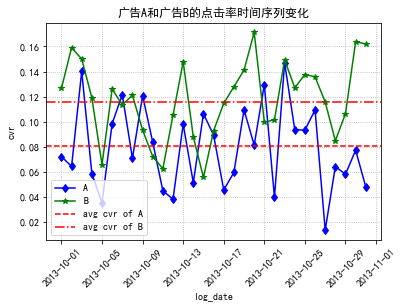

In [11]:
plt.plot(x, y1, 'b-d', label='A')
plt.plot(x, y2, 'g-*', label='B')
plt.axhline(y=y3, c = 'r', ls='--', label='avg cvr of A')
plt.axhline(y=y4, c = 'r', ls='-.', label='avg cvr of B')
plt.grid(linestyle=':')
plt.xticks(rotation=45)
plt.xlabel("log_date")
plt.ylabel("cvr")
plt.title('广告A和广告B的点击率时间序列变化')
plt.legend()
plt.show()